In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl03 as mklmodel
from mgds.data_modeling import constants as model_constants
from mgds.data_modeling import data as feature_data
from ml.edward import models as ed_models
from ml.api import trainer as ml_trainer
SEED = model_constants.SEED

2017-04-14 13:41:06,182:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-04-14 13:41:12,366:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-14 13:41:46,915:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-14 13:41:54,627:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [3]:
#target_drugs = mgds_drugs.DEFAULT_DRUGS
target_drugs = mgds_drugs.GDSC_PAPER_DRUGS + mgds_drugs.DEFAULT_DRUGS
target_drugs[:10]

['SUNITINIB',
 'SB590885',
 'YM201636',
 'KIN001055',
 'GSK690693',
 'YM155',
 'GEMCITABINE',
 'JNKINHIBITORVIII',
 'LY317615',
 'AZD7762']

In [94]:
import imp
imp.reload(mkl)

<module 'mgds.data_modeling.nbfn.mkl' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/nbfn/mkl.py'>

In [95]:
site = 'LUNG'
na_y_thresh = .5

In [96]:
def get_rx_data(ge_src, rx_src):
    return mkl.get_rx_modeling_data(
        drugs=target_drugs, genes=X_rppa.columns.tolist(), 
        ge_src=ge_src, rx_src=rx_src, site=site,
        na_y_thresh=na_y_thresh, verify=True
    )

In [89]:
d_raw = {}

In [636]:
d_raw[src.CCLE_v1] = get_rx_data(src.CCLE_v1, src.CTD_v2)
#d_raw[src.CCLE_v1] = get_rx_data(src.CCLE_v1, src.GDSC_v2)

2017-04-14 20:32:35,898:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-14 20:32:51,959:INFO:mgds.data_modeling.nbfn.mkl: Removing 6 drugs of 77 due to having more than 50.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 804, Records removed = 163 (%16.86)
[Remove Y records with null Y values] Records before = 967, Records after = 804, Records removed = 163 (%16.86)


In [637]:
d_raw[src.GDSC_v2] = get_rx_data(src.GDSC_v2, src.GDSC_v2)
#d_raw[src.GDSC_v2] = get_rx_data(src.GDSC_v2, src.GDSC_v2)

2017-04-14 20:33:16,146:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-14 20:33:28,968:INFO:mgds.data_modeling.nbfn.mkl: Removing 44 drugs of 233 due to having more than 50.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 976, Records removed = 497 (%33.74)
[Remove Y records with null X values] Records before = 1473, Records after = 976, Records removed = 497 (%33.74)
[Remove X records with null Y values] Records before = 976, Records after = 970, Records removed = 6 (%0.61)
[Remove Y records with null Y values] Records before = 976, Records after = 970, Records removed = 6 (%0.61)


In [92]:
if site == 'BREAST':
    d_raw[src.NCIDREAM_v1] = get_rx_data(src.NCIDREAM_v1, src.NCIDREAM_v1)

In [638]:
d_raw[src.NCI60_v2] = get_rx_data(src.NCI60_v2, src.NCI60_v2)
#d_raw[src.NCI60_v2] = get_rx_data(src.NCI60_v2, src.GDSC_v2)

2017-04-14 20:33:29,749:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning:

indexing past lexsort depth may impact performance.



[Remove X records with null X values] Records before = 1473, Records after = 52, Records removed = 1421 (%96.47)
[Remove Y records with null X values] Records before = 1473, Records after = 52, Records removed = 1421 (%96.47)
[Remove X records with null Y values] Records before = 52, Records after = 50, Records removed = 2 (%3.85)
[Remove Y records with null Y values] Records before = 52, Records after = 50, Records removed = 2 (%3.85)


# Verification

In [41]:
#dv = pd.read_pickle('/Users/eczech/data/research/mgds/import/ccle_v1_gene-expression.pkl')
#dv = pd.read_pickle('/Users/eczech/data/research/mgds/import/ctd_v2_drug-sensitivity.pkl')
#dv = pd.read_pickle('/Users/eczech/data/research/mgds/import/gdsc_v2_drug-sensitivity.pkl')
dv = pd.read_pickle('/Users/eczech/data/research/mgds/import/gdsc_v2_gene-expression.pkl')

In [37]:
X_drug, Y_drug = d_raw[src.GDSC_v2]

In [42]:
X_drug.head()

,,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZSWIM7,ZSWIM8,ZUFSP,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,,,,,,,,,,,,,,,,,,
201T,LUNG,3.162073,3.379281,2.700304,3.474596,3.109329,4.756341,3.868514,3.092879,2.750371,4.674570,...,5.309513,5.408674,6.674838,6.280829,3.800810,2.711616,4.778416,4.705113,4.663415,7.947954
A427,LUNG,5.848385,2.932952,3.037659,3.559562,3.217063,5.105380,4.174823,3.143987,3.005977,4.065328,...,4.244532,5.755693,6.739280,9.121153,4.223326,3.043967,4.703746,4.979427,4.292272,6.667606
A549,LUNG,5.351535,3.385313,2.876303,3.333856,3.114323,5.381566,4.103707,9.450859,2.846056,4.713336,...,6.214746,6.044586,5.959830,8.036890,3.589504,2.912747,4.774998,4.912069,4.822774,6.777464
ABC1,LUNG,3.510294,3.309219,2.985962,3.447728,3.409885,4.961180,3.548047,3.242520,2.819687,4.211096,...,4.306933,5.736916,6.027559,9.847387,4.211336,3.167960,4.358897,3.896836,5.410401,7.081920
BEN,LUNG,3.794517,3.478989,2.883345,3.394721,2.968360,5.350990,5.262612,3.121429,2.837785,3.779304,...,4.122315,5.872197,7.226430,9.587397,4.015504,2.953253,4.059184,3.553369,4.560439,7.039471


In [43]:
# dv[(dv['GENE_ID:HGNC'] == 'AACS') & (dv['CELL_LINE_ID'] == 'BEN')]
# #dv[(dv['CELL_LINE_ID'] == 'A427') & (dv['DRUG_NAME'].str.upper() == 'AFATINIB')]

,GENE_ID:HGNC,CELL_LINE_ID:COSMIC,VALUE,CELL_LINE_ID
7073613,AACS,753534,5.262612,BEN


In [44]:
#dv.head()

# EDA

In [98]:
X_drug, Y_drug = d_raw[src.NCI60_v2]

In [99]:
Y_drug.head()

,,17AAG,AFATINIB,AXITINIB,BLEOMYCIN,BORTEZOMIB,BOSUTINIB,BRYOSTATIN1,CAMPTOTHECIN,CISPLATIN,CRIZOTINIB,...,SN38,SUNITINIB,TAMOXIFEN,TEMSIROLIMUS,THAPSIGARGIN,TRAMETINIB,VINBLASTINE,VINORELBINE,VORINOSTAT,XL184
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,,,,,,,,,,,,,,,,,,
EKVX,LUNG,-12.815531,-18.420681,-10.660969,-10.920832,-19.000165,NaN,-11.747370,-15.890715,-11.900335,-12.180675,...,-14.702006,-11.766210,-11.798617,-18.047662,-18.178909,-18.121345,-17.758123,-18.420681,-13.467564,-11.881339
HOP62,LUNG,-15.984546,-12.905989,-11.628055,-16.225413,-19.188209,-12.272779,-12.182594,-18.604888,-13.274205,-13.170787,...,-18.996327,-12.859938,-11.721803,-19.387766,-18.552257,-15.185549,-21.100405,-18.029241,-13.366506,-12.100085
HOP92,LUNG,-12.690533,NaN,-11.823774,-16.263035,-19.687103,-13.078683,-12.945645,-15.850996,-12.537576,-14.379644,...,-18.800607,-14.638685,-12.475006,-17.223336,-19.399279,-18.420681,-20.062787,-16.866436,-12.741930,-17.177285
NCIH226,LUNG,-12.693823,-13.101709,-14.068795,-15.286972,-20.838395,-11.317206,-11.459198,-16.366775,-12.262910,-13.228351,...,-18.996327,-11.743184,-11.585687,-18.121345,-17.849640,-12.341856,-20.683192,-17.315440,-12.379273,-13.285916
NCIH322M,LUNG,-16.141122,-16.095070,-10.050784,-10.996006,-17.725300,-14.748058,-12.503037,-15.371400,-12.024525,-12.169162,...,-17.373005,-12.245915,-11.794762,-18.368873,-18.996327,-18.247987,-20.822653,-18.420681,-13.981808,-12.226727


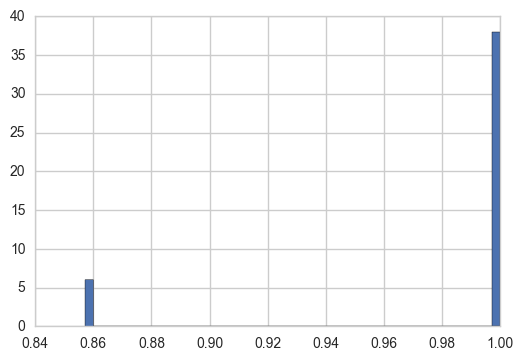

In [100]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [101]:
X_drug.shape, Y_drug.shape

((7, 13230), (7, 44))

# Prep

In [141]:
# for g in ['YAP1', 'TP53', 'RB1', 'BRAF']:
#     print(g, g in shared_genes)

In [600]:
#import fancyimpute
from sklearn.preprocessing import Imputer, StandardScaler

def impute(d):
    n_na = d.isnull().sum().sum()
    n = d.shape[0] * d.shape[1]
    pct_na = round(100. * n_na / n, 2)
    print('Imputing {} values of {} ({}%)'.format(n_na, n, pct_na))
    
    imputer = Imputer(strategy='mean')
    d_imp = imputer.fit_transform(d)

    d = pd.DataFrame(d_imp, index=d.index, columns=d.columns)
    return d, imputer

def scale(d):
    scaler = StandardScaler()
    d_scale = scaler.fit_transform(d)
    d = pd.DataFrame(d_scale, index=d.index, columns=d.columns)
    return d, scaler

def get_shared_genes(d_raw):
    genes = []
    for k in d_raw:
        X = d_raw[k][0]
        genes.append(set(X.columns.tolist()))
    genes = list(set.intersection(*genes))
    return genes

def prep(d_raw, genes, max_drugs=None):
    d_prep = {}
    for k, v in d_raw.items():
        print('Running data prep for source "{}"'.format(k))
        X, Y = v

        # Subset to given gene list
        X = X[genes]
        
        # Downsample drugs if necessary
        cols = Y.columns.tolist()
        if max_drugs is not None and len(cols) > max_drugs:
            np.random.seed(1)
            c = list(np.random.choice(cols, replace=False, size=max_drugs))
            c += mgds_drugs.DEFAULT_DRUGS
            c = list(np.unique(c))
            Y = Y.filter(items=c)
        
        # Impute missing Y values, if any
        Y_imputer = None
        if Y.isnull().any().any():
            Y, Y_imputer = impute(Y)

        assert np.all(X.notnull())
        assert np.all(Y.notnull())

        X, X_scaler = scale(X)
        Y, Y_scaler = scale(Y)
        X_scaler = None
        Y_scaler = None

        d_prep[k] = {
            'X': X, 'Y': Y, 'Y_imputer': Y_imputer, 
            'X_scaler': X_scaler, 'Y_scaler': Y_scaler
        }
    print('Data prep complete')
    return d_prep

shared_genes = get_shared_genes(d_raw)
d_train = prep(d_raw, shared_genes, max_drugs=20)

Running data prep for source "ccle_v1"
Imputing 376 values of 3300 (11.39%)
Running data prep for source "gdsc_v2"
Imputing 480 values of 4225 (11.36%)
Running data prep for source "nci60_v2"
Imputing 37 values of 208 (17.79%)
Data prep complete


In [601]:
for k, v in d_train.items():
    print(k, v['X'].shape, v['Y'].shape)

ccle_v1 (132, 13230) (132, 25)
gdsc_v2 (169, 13230) (169, 25)
nci60_v2 (8, 13230) (8, 26)


In [550]:
X, Y = d_train[src.CCLE_v1]['X'], d_train[src.CCLE_v1]['Y']

In [554]:
# Xdt = X.describe(percentiles=[.1, .9]).T
# Xdt['diff'] = Xdt['90%'] - Xdt['10%']
# Xdt['diff'].describe()

In [551]:
X.describe().T[['min', 'max', 'mean', 'std']].describe()

,min,max,mean,std
count,13230.000000,13230.000000,13230.000000,13230.000000
mean,-2.194306,3.449804,-0.013757,0.995148
std,1.243722,2.188806,0.315999,0.290605
min,-20.346400,-0.336800,-1.513301,0.060089
25%,-2.844350,2.248850,-0.211204,0.846064
50%,-2.031300,2.931750,-0.029133,0.995500
75%,-1.236025,3.922175,0.188279,1.151547
max,-0.016100,35.735500,1.436773,3.718679


In [547]:
Y.describe().T[['min', 'max', 'mean', 'std']].describe()

,min,max,mean,std
count,17.000000,17.000000,1.700000e+01,1.700000e+01
mean,-3.172488,2.772283,2.144486e-17,1.003565e+00
std,0.857284,0.586335,3.911249e-16,1.110223e-16
min,-4.741399,2.056269,-6.606221e-16,1.003565e+00
25%,-4.003318,2.283171,-2.897603e-16,1.003565e+00
50%,-2.813760,2.877502,8.818793e-17,1.003565e+00
75%,-2.561079,3.033399,3.086577e-16,1.003565e+00
max,-2.037399,4.113538,5.133797e-16,1.003565e+00


# Training

In [234]:
from ml.tensorflow import utilities as tf_utils
from edward.models import Dirichlet
tf.reset_default_graph()
#v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
#v = tf.contrib.distributions.Dirichlet(alpha=1.*tf.ones([4])).sample(1000)
#v = tf.nn.softplus(tf.random_normal([4]))

# v = Dirichlet(alpha=1.*tf.ones([4]))#.sample(1000)
# v2 = tf.gather(v, 1)

# v = tf.concat([tf.conc])
# v, v2 = tf_utils.tf_eval([v, v2])

v = tf.constant([[1, 2, 3], [3, 4, 5]])
#v, v2 = tf_utils.tf_eval(v.get_shape())
v.get_shape().as_list() == [2, 3]

True

In [15]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [65]:
sources = sorted(list(d_raw.keys()))
sources = [s for s in sources if s != src.GDSC_v2]
sources

['ccle_v1', 'nci60_v2', 'ncidream_v1']

In [17]:
def get_training_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(sources, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP
    )
    ! rm -rf /tmp/mkl3tr/*
    est.set_log_dir('/tmp/mkl3tr/{}'.format(fold_id))
    return est

In [18]:
est = get_training_mkl_model(0)

X = [d_train[s]['X'].values for s in sources]
Y = [d_train[s]['Y'].values for s in sources]

est.train({'X': X, 'Y': Y})

qA                  3
qBccle_v1          72
qBnci60_v2         42
qBncidream_v1       5
qWccle_v1        6408
qWnci60_v2       3738
qWncidream_v1     445
dtype: int64
10713


2017-04-14 11:49:23,314:INFO:root: On iteration 0 of at most 2500 (loss = 21420.08203125, loss change = None)
2017-04-14 11:49:23,860:INFO:root: On iteration 100 of at most 2500 (loss = 9140.8720703125, loss change = -35.72919845581055)
2017-04-14 11:49:24,408:INFO:root: On iteration 200 of at most 2500 (loss = 7908.01171875, loss change = -1.26708984375)
2017-04-14 11:49:25,024:INFO:root: On iteration 300 of at most 2500 (loss = 7106.21923828125, loss change = 24.338964462280273)
2017-04-14 11:49:25,207:INFO:root: Converged on iteration 331 (loss = 7049.46337890625, loss change = -0.09091796725988388)


BayesianModelEstimator(fail_if_not_converged=False,
            inference_fn=<class 'edward.inferences.map.MAP'>,
            max_steps=2500,
            model=<mgds.data_modeling.nbfn.model_mkl03.MTKLModel object at 0x154e15dd8>,
            n_collect=1, n_loss_buffer=10, n_print_progress=100,
            n_samples=1, optimizer=None, random_state=8392,
            save_tf_model=True, tol=0.1)

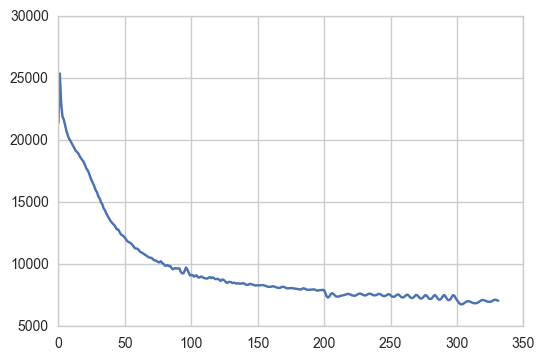

In [19]:
plt.plot(est.losses_)

In [24]:
g_pred = src.NCI60_v2
X_pred, Y_true = d_train[g_pred]['X'], d_train[g_pred]['Y']
X_pred.shape, Y_true.shape

((5, 12190), (5, 42))

In [25]:
Y_pred = est.criticism_args_[0](X_pred.values, g_pred)
Y_pred.shape

(5, 42)

In [26]:
d_pred = mkl.stack_predictions(Y_pred, Y_true).assign(Model='MKL', Fold=0)

d_score = mkl.score_predictions(d_pred.reset_index(), mkl.SCORE_FN_MSE)
d_score.head()

,Model,Task,count,mean,std,min,25%,50%,75%,max
0,MKL,17AAG,1.0,0.586108,NaN,0.586108,0.586108,0.586108,0.586108,0.586108
1,MKL,AFATINIB,1.0,0.585778,NaN,0.585778,0.585778,0.585778,0.585778,0.585778
2,MKL,AXITINIB,1.0,0.597318,NaN,0.597318,0.597318,0.597318,0.597318,0.597318
3,MKL,BLEOMYCIN,1.0,0.588602,NaN,0.588602,0.588602,0.588602,0.588602,0.588602
4,MKL,BORTEZOMIB,1.0,0.588460,NaN,0.588460,0.588460,0.588460,0.588460,0.588460


In [23]:
qA = est.get_tensor('qA')
pd.Series(qA / np.sum(qA), index=sources)

ccle_v1        0.433748
nci60_v2       0.429455
ncidream_v1    0.136797
dtype: float32

# Cross Validation

In [437]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [627]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [628]:
def get_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(sources, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP, tol=.01
    )
    est.set_log_dir('/tmp/mkl3cv/{}'.format(fold_id))
    return est

sources = sorted(list(d_raw.keys()))
#sources = [s for s in sources if s != src.GDSC_v2]
sources

['ccle_v1', 'gdsc_v2', 'nci60_v2']

In [629]:
from sklearn.model_selection import KFold

def partition(d_train, K):
    d_cv = {}
    for source in d_train.keys():
        X, Y = d_train[source]['X'], d_train[source]['Y']
        cv = KFold(n_splits=K, random_state=SEED, shuffle=True)
        folds = []
        for train, test in cv.split(X):
            folds.append({
                'X_train': X.iloc[train, :],
                'X_test': X.iloc[test, :],
                'Y_train': Y.iloc[train, :],
                'Y_test': Y.iloc[test, :]
            })
        d_cv[source] = folds
    return d_cv

K = 4
d_cv = partition(d_train, K)

In [630]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from ml.edward import models as ed_models
    
ests = {
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         #('pca', PCA(n_components=.9999)),
#         ('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
#     ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9999)),
        ('est', MultiOutputRegressor(RidgeCV(alphas=(1., 10., 50., 100., 1000., 10000.))))
    ]),
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
# #         ('pca', PCA(n_components=.999999)),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-1, 3, 5)})))
#     ]),
    'mkl': lambda i: get_mkl_model(i),
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}


In [631]:
def get_training_results(ests, d_train, d_cv, sources, n_folds, refit=False):
    
    def train_standard(est_name):
        
        models = {}
        d_pred_test = []
        d_pred_train = []
        
        def get_standard_predictions(X, Y, est, est_name, fold, source):
            Yp = est.predict(X)
            Yp = mkl.stack_predictions(Yp, Y)
            Yp = Yp.assign(Model=est_name, Fold=i, Source=source)
            return Yp
        
        for source in sources:
#             if refit:
#                 est = ests[est_name](0)
#                 X, Y = d_train[source]['X'], d_train[source]['Y']
#                 est.fit(X, Y)
#                 refit_models[est_name] = est
            
            for i, d_fold in enumerate(d_cv[source]):
                i += 1
                est = ests[est_name](i)
                est.fit(d_fold['X_train'].values, d_fold['Y_train'].values)
                
                d_pred_test.append(get_standard_predictions(
                    d_fold['X_test'].values, d_fold['Y_test'], est, est_name, i, source
                ))
                d_pred_train.append(get_standard_predictions(
                    d_fold['X_train'].values, d_fold['Y_train'], est, est_name, i, source
                ))
                
        return pd.concat(d_pred_test), pd.concat(d_pred_train), models
    
    def train_mkl(est_name):
        
        models = {'train_pred': {}}
        d_pred_test = []
        d_pred_train = []
        
        def get_mkl_predictions(X, Y, est, est_name, fold, source):
            Yp = est.criticism_args_[0](X, source)
            Yp = mkl.stack_predictions(Yp, Y)
            Yp = Yp.assign(Model=est_name, Fold=i, Source=source)
            return Yp
        
        # Refit model
#         X = [d_train[s]['X'].values for s in sources]
#         Y = [d_train[s]['Y'].values for s in sources]

        for i in range(n_folds):
            X_train = [d_cv[s][i]['X_train'].values for s in sources]
            Y_train = [d_cv[s][i]['Y_train'].values for s in sources]
#             X_test = [d_cv[s][i]['X_test'].values for s in sources]
#             Y_test = [d_cv[s][i]['Y_test'].values for s in sources]
            
            est = ests[est_name](i+1)
            est.train({'X': X_train, 'Y': Y_train})
            
            for source in sources:
                    
                X_train_pred_1 = est.criticism_args_[0](d_cv[source][i]['X_train'].values, source)
                X_train_pred_2 = est.criticism_args_[2](source)
                Y_train_true = d_cv[source][i]['Y_train'].values
                models['train_pred'][source] = (X_train_pred_1, X_train_pred_2, Y_train_true)
                
                print('MKL: ', source, i, d_cv[source][i]['X_test'].values.shape, d_cv[source][i]['Y_test'].shape)
                d_pred_test.append(get_mkl_predictions(
                    d_cv[source][i]['X_test'].values, 
                    d_cv[source][i]['Y_test'], 
                    est, est_name, i+1, source
                ))
                d_pred_train.append(get_mkl_predictions(
                    d_cv[source][i]['X_train'].values, 
                    d_cv[source][i]['Y_train'], 
                    est, est_name, i+1, source
                ))
            
        return pd.concat(d_pred_test), pd.concat(d_pred_train), models
    
    
    models = {}
    d_pred_test = []
    d_pred_train = []
    
    for est_name in ests:
        print('Training estimator "{}"'.format(est_name))
        if est_name == 'mkl':
            train_fn = train_mkl
        else: 
            train_fn = train_standard
        dp_test, dp_train, rmodels = train_fn(est_name)
        d_pred_test.append(dp_test)
        d_pred_train.append(dp_train)
        models[est_name] = rmodels
        
    print('Training Complete')
    return pd.concat(d_pred_test), pd.concat(d_pred_train), models
    

In [632]:
! rm -rf /tmp/mkl3cv/*
d_pred_test, d_pred_train, model_res = get_training_results(ests, d_train, d_cv, sources, K, refit=False)

Training estimator "baseline"
Training estimator "mkl"
qA               3
qBccle_v1       25
qBgdsc_v2       25
qBnci60_v2      26
qWccle_v1     5775
qWgdsc_v2     5775
qWnci60_v2    6006
dtype: int64
17635


2017-04-14 20:30:29,366:INFO:root: On iteration 0 of at most 2500 (loss = 22551.556640625, loss change = None)
2017-04-14 20:30:30,030:INFO:root: On iteration 100 of at most 2500 (loss = 20723.259765625, loss change = -7.789258003234863)
2017-04-14 20:30:30,691:INFO:root: On iteration 200 of at most 2500 (loss = 20026.33203125, loss change = -2.3558592796325684)
2017-04-14 20:30:31,185:INFO:root: Converged on iteration 274 (loss = 19940.439453125, loss change = 0.004687500186264515)


MKL:  ccle_v1 0 (33, 13230) (33, 25)
MKL:  gdsc_v2 0 (43, 13230) (43, 25)
MKL:  nci60_v2 0 (2, 13230) (2, 26)
qA               3
qBccle_v1       25
qBgdsc_v2       25
qBnci60_v2      26
qWccle_v1     5800
qWgdsc_v2     5800
qWnci60_v2    6032
dtype: int64
17711


2017-04-14 20:30:37,744:INFO:root: On iteration 0 of at most 2500 (loss = 22633.009765625, loss change = None)
2017-04-14 20:30:38,399:INFO:root: On iteration 100 of at most 2500 (loss = 20582.083984375, loss change = -10.909570693969727)
2017-04-14 20:30:39,056:INFO:root: On iteration 200 of at most 2500 (loss = 20073.48828125, loss change = -2.212695360183716)
2017-04-14 20:30:39,703:INFO:root: On iteration 300 of at most 2500 (loss = 19997.861328125, loss change = 0.29804688692092896)
2017-04-14 20:30:39,711:INFO:root: Converged on iteration 301 (loss = 19990.068359375, loss change = -0.007031249813735485)


MKL:  ccle_v1 1 (33, 13230) (33, 25)
MKL:  gdsc_v2 1 (42, 13230) (42, 25)
MKL:  nci60_v2 1 (2, 13230) (2, 26)
qA               3
qBccle_v1       25
qBgdsc_v2       25
qBnci60_v2      26
qWccle_v1     5800
qWgdsc_v2     5800
qWnci60_v2    6032
dtype: int64
17711


2017-04-14 20:30:46,822:INFO:root: On iteration 0 of at most 2500 (loss = 22477.974609375, loss change = None)
2017-04-14 20:30:47,513:INFO:root: On iteration 100 of at most 2500 (loss = 20148.32421875, loss change = -12.883203506469727)
2017-04-14 20:30:48,032:INFO:root: On iteration 200 of at most 2500 (loss = 19843.9140625, loss change = -1.4578125476837158)
2017-04-14 20:30:48,480:INFO:root: Converged on iteration 268 (loss = 19795.08984375, loss change = 0.0031250000465661287)


MKL:  ccle_v1 2 (33, 13230) (33, 25)
MKL:  gdsc_v2 2 (42, 13230) (42, 25)
MKL:  nci60_v2 2 (2, 13230) (2, 26)
qA               3
qBccle_v1       25
qBgdsc_v2       25
qBnci60_v2      26
qWccle_v1     5800
qWgdsc_v2     5800
qWnci60_v2    6032
dtype: int64
17711


2017-04-14 20:30:55,358:INFO:root: On iteration 0 of at most 2500 (loss = 22418.24609375, loss change = None)
2017-04-14 20:30:56,031:INFO:root: On iteration 100 of at most 2500 (loss = 20370.31640625, loss change = -11.348437309265137)
2017-04-14 20:30:56,694:INFO:root: On iteration 200 of at most 2500 (loss = 19845.625, loss change = -1.7820312976837158)
2017-04-14 20:30:57,368:INFO:root: On iteration 300 of at most 2500 (loss = 19766.162109375, loss change = -0.28886717557907104)
2017-04-14 20:30:57,762:INFO:root: Converged on iteration 358 (loss = 19737.5859375, loss change = -0.0035156249068677425)


MKL:  ccle_v1 3 (33, 13230) (33, 25)
MKL:  gdsc_v2 3 (42, 13230) (42, 25)
MKL:  nci60_v2 3 (2, 13230) (2, 26)
Training estimator "ridge"
Training Complete


In [633]:
[x.shape for x in model_res['mkl']['train_pred'][src.CCLE_v1]]

[(99, 25), (99, 25), (99, 25)]

In [634]:
model_res['mkl']['train_pred'][src.CCLE_v1]

(array([[-0.31773611,  0.44150675, -0.40691704, ..., -0.26626694,
          0.50292405,  0.01409523],
        [ 1.01162207, -0.19366419, -0.38368351, ...,  0.17401956,
          0.33234563,  0.36692022],
        [-0.62296302, -0.06645207, -0.15421769, ...,  0.07326823,
         -0.11339325,  0.5991014 ],
        ..., 
        [ 0.24765764, -0.06950126, -0.28753451, ..., -1.22747584,
          0.45887415,  0.44865147],
        [-1.06706438,  0.37419369, -0.1994568 , ...,  0.62931802,
          1.26772316,  0.95183302],
        [-0.19520756, -0.03186875,  0.30851301, ..., -0.17761087,
          0.18291451,  0.44048024]]),
 array([[-0.3177363 ,  0.44150686, -0.40691707, ..., -0.26626691,
          0.50292444,  0.01409533],
        [ 1.01162136, -0.19366421, -0.3836835 , ...,  0.17401949,
          0.33234587,  0.3669202 ],
        [-0.62296337, -0.06645209, -0.15421766, ...,  0.07326818,
         -0.1133933 ,  0.59910142],
        ..., 
        [ 0.24765761, -0.06950121, -0.28753453, ...,

In [610]:
d_pred_test.head()

Pred    Actual  Fold  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS Task                                  
CALU3             LUNG              AG014699  -0.000529 -0.729546     1   
                                    AR42      -0.041004  0.722454     1   
                                    AUY922     0.030317 -0.396545     1   
                                    AZD6482   -0.003692  0.474117     1   
                                    BMS345541 -0.005848  2.215009     1   

                                                  Model   Source  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS Task                          
CALU3             LUNG              AG014699   baseline  ccle_v1  
                                    AR42       baseline  ccle_v1  
                                    AUY922     baseline  ccle_v1  
                                    AZD6482    baseline  ccle_v1  
                                    BMS345541  baseline  ccle_v1

In [635]:
# def plot_scores(d):
#     traces = []
#     for k, g in d.groupby('Task'):
#         trace = go.Scatter(x=g['Model'], y=g['mean'], mode='markers', name=k)
#         traces.append(trace)
#     layout = go.Layout()
#     fig = go.Figure(data=traces, layout=layout)
#     plty.offline.iplt(fig)

def plot_scores(d):
    traces = []
    for k, g in d.groupby('Source'):
        trace = go.Box(x=g['Model'], y=g['mean'], boxpoints='all', boxmean='sd', name=k)
        traces.append(trace)
    layout = go.Layout(boxmode='group')
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)

from sklearn.metrics import mean_squared_error, r2_score

def get_scores(d, score_fn):
    d_score = d.groupby(['Model', 'Source', 'Task', 'Fold']).apply(score_fn).rename('Score').reset_index()
    return d_score.groupby(['Model', 'Source', 'Task'])['Score'].describe().unstack().reset_index()


score_fn = mkl.SCORE_FN_PEARSON
#score_fn = mkl.SCORE_FN_SPEARMAN
#score_fn = mkl.SCORE_FN_MSE

d_score = get_scores(d_pred_test.reset_index(), score_fn)
#d_score = get_scores(d_pred_train.reset_index(), score_fn)
plot_scores(d_score)

In [614]:
d_pred_test.head()

Pred    Actual  Fold  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS Task                                  
CALU3             LUNG              AG014699  -0.000529 -0.729546     1   
                                    AR42      -0.041004  0.722454     1   
                                    AUY922     0.030317 -0.396545     1   
                                    AZD6482   -0.003692  0.474117     1   
                                    BMS345541 -0.005848  2.215009     1   

                                                  Model   Source  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS Task                          
CALU3             LUNG              AG014699   baseline  ccle_v1  
                                    AR42       baseline  ccle_v1  
                                    AUY922     baseline  ccle_v1  
                                    AZD6482    baseline  ccle_v1  
                                    BMS345541  baseline  ccle_v1

In [243]:
d_pred_test.reset_index().groupby(['Model', 'Source'])['Fold'].nunique()

Model     Source  
baseline  ccle_v1     3
          gdsc_v2     3
          nci60_v2    3
mkl       ccle_v1     3
          gdsc_v2     3
          nci60_v2    3
ridge     ccle_v1     3
          gdsc_v2     3
          nci60_v2    3
Name: Fold, dtype: int64

5 6 25


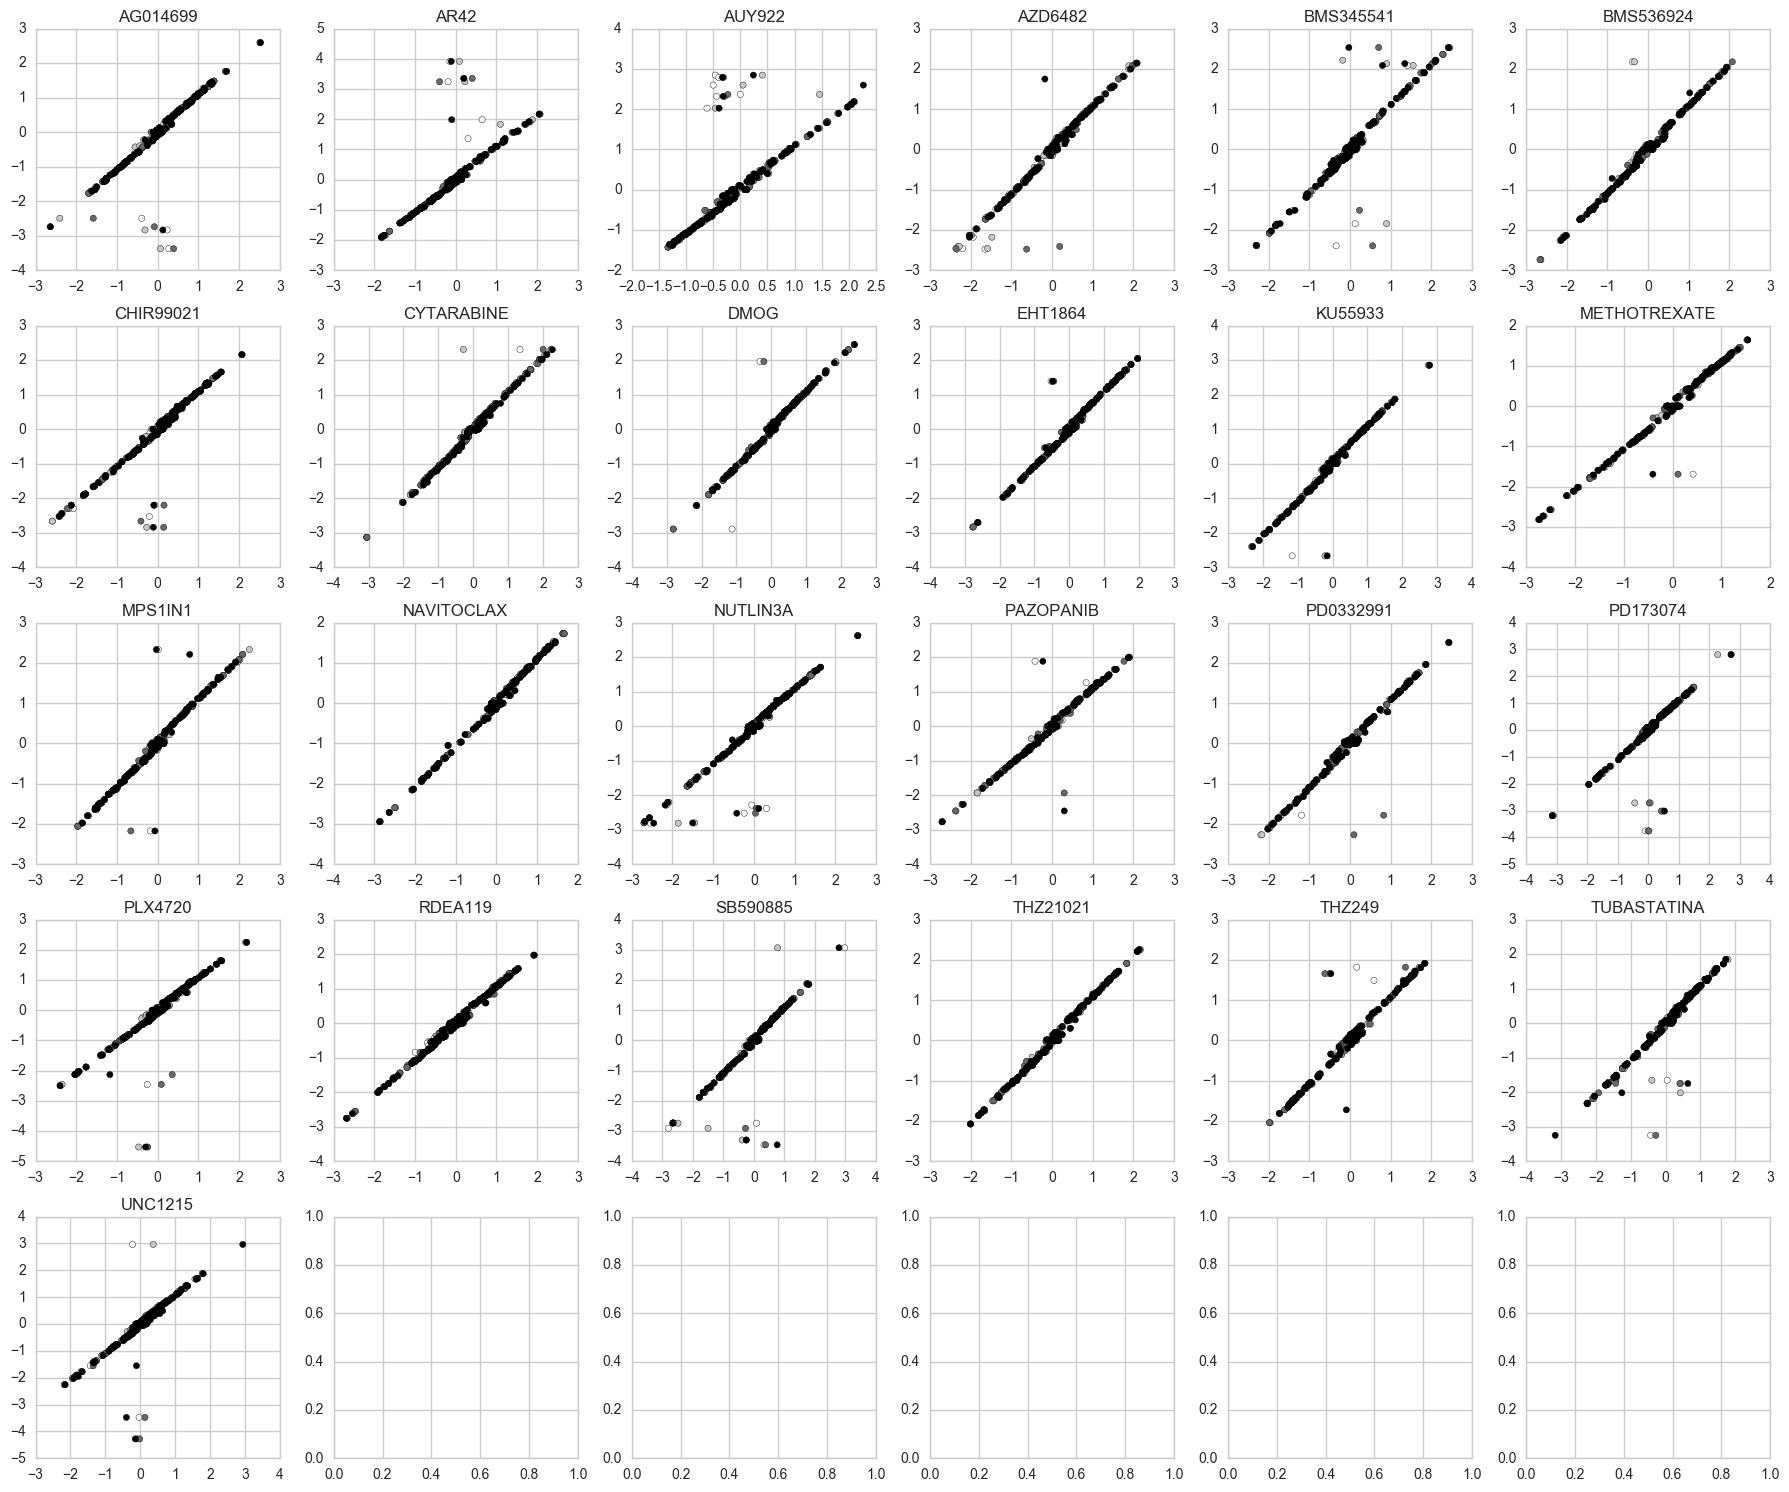

In [619]:
def plot_predictions(d_pred, model, source, ncols=6):

    d = d_pred
    d = d[d['Model'] == model]
    d = d[d['Source'] == source]
    
    tasks = d['Task'].unique()
    ntasks = len(tasks)
    nrows = int(ntasks / float(ncols)) + 1 if ntasks % ncols != 0 else int(ntasks / float(ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    print(nrows, ncols, ntasks)
    axs = axs.ravel()
    fig.set_size_inches((ncols*3, nrows*3))

    for i, t in enumerate(tasks):
        dt = d[d['Task'] == t]
        stats = dt['Actual'].describe()
        vmin, vmax = stats['min']*1.1, stats['max']*1.1
        axs[i].scatter(dt['Pred'], dt['Actual'], c=dt['Fold'])
        axs[i].set_title('{}'.format(t))
#         axs[i].set_xlim(vmin, vmax)
#         axs[i].set_ylim(vmin, vmax)
    plt.tight_layout()
        
#plot_predictions(d_pred_test.reset_index(), 'mkl', src.GDSC_v2)
#plot_predictions(d_pred_test.reset_index(), 'mkl', src.NCI60_v2)
#plot_predictions(d_pred_test.reset_index(), 'mkl', src.CCLE_v1)
plot_predictions(d_pred_train.reset_index(), 'mkl', src.CCLE_v1)

# Pearson TF

In [ ]:

def _std(Y):
    devs_squared = tf.square(Y - tf.reduce_mean(Y, axis=0))
    return tf.sqrt(tf.reduce_mean(devs_squared, axis=0))

def _pearson(Y1, Y2):
    p_top = tf.reduce_mean((Y1 - tf.reduce_mean(Y1, axis=0)) * (Y2 - tf.reduce_mean(Y2, axis=0)), axis=0)
    p_bottom = _std(Y1) * _std(Y2)
    return p_top / p_bottom

x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y = x + np.random.randn(3, 3)

top = np.mean((x - np.mean(x, axis=0)) * (y - np.mean(y, axis=0)), axis=0)
bottom = np.std(x, axis=0) * np.std(y, axis=0)
top / bottom

from ml.tensorflow.utilities import tf_eval
tf.reset_default_graph()
tf_eval(_pearson(tf.constant(x, dtype=tf.float64), tf.constant(y, dtype=tf.float64)))

[pd.Series(x[:, i]).corr(pd.Series(y[:, i])) for i in range(3)]